# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Polarizacion-de-la-fuente-de-luz" data-toc-modified-id="Polarizacion-de-la-fuente-de-luz-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Polarizacion de la fuente de luz</a></div><div class="lev2 toc-item"><a href="#Load-intensity-with-1-polarizer" data-toc-modified-id="Load-intensity-with-1-polarizer-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load intensity with 1 polarizer</a></div><div class="lev2 toc-item"><a href="#Fitting" data-toc-modified-id="Fitting-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fitting</a></div><div class="lev2 toc-item"><a href="#Resultados" data-toc-modified-id="Resultados-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Resultados</a></div><div class="lev3 toc-item"><a href="#Stokes-Parameters" data-toc-modified-id="Stokes-Parameters-131"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Stokes Parameters</a></div><div class="lev2 toc-item"><a href="#Verificación" data-toc-modified-id="Verificación-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Verificación</a></div>

# Polarizacion de la fuente de luz

**Autor**: Luis Miguel Sanchez Brea

**Fecha**:   12/03/2018

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

1. Diodo láser de Roithner .... de longitud de onda $\lambda$=850 nm (corriente = 314 mA).
1. Lente colimadora de Thorlabs DG10-600-B.
1. Difusor.
1. Lámina retardadora $\lambda/4$ ... de Throlabs para hacer el haz de luz circular.
1. Polarizador 1

**Procedimiento**:
Se supone que la fuente tiene que ser aproximadamente circulamente polarizada. Por ello, al pasar por un polarizador lineal, tiene que fluctuar poco.

1. Se gira el polarizador una vuelta para ver el rizado de la fuente. 


**Resultado**

Vector de Jones de la fuente de luz


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:898: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


In [2]:
from __future__ import print_function

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import pprint

from scipy.io import loadmat
from scipy import optimize

from phyton_optics import degrees
from phyton_optics.polarization_stokes import polarized_light, polarizer_linear, intensity

from polarimeter.polarimeter import get_polarimeter_parameters, intensity
from polarimeter.utils import plot_experiment_residuals_1D

## Load intensity with 1 polarizer
With this experiment we determine the circularity of the light source after passing through a waveplate

(1.5056210710527376, 1.8402035312866794)

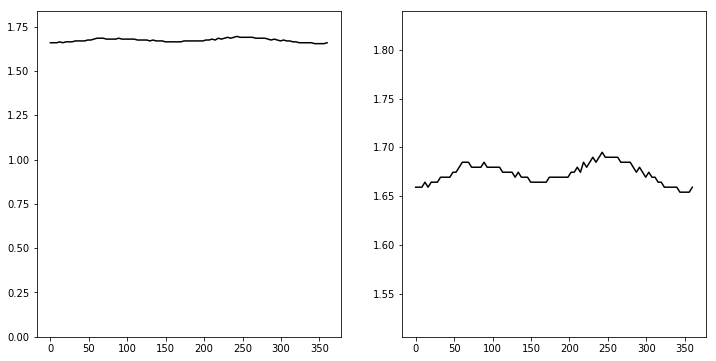

In [3]:
#Load data and represent
filename='step1_source_2018-03-21.npy'
data_1=np.load(filename)
angles_1=data_1[:,0]
intensities_1=data_1[:,1]
I1=sp.mean(intensities_1)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(angles_1,intensities_1,'k')
plt.ylim(0,I1*1.1)

plt.subplot(122)
plt.plot(angles_1,intensities_1,'k')
plt.ylim(I1*0.9,I1*1.1)

## Fitting


In [4]:
#Fitting parameters 
# Fit the first set
sin_func = lambda par, x: par[0]+par[1]*np.cos(2*np.pi/par[2]*(x-par[3])) # Target function
errfunc = lambda par, x, y: sin_func(par, x) - y # Distance to the target function

In [5]:
#Fitting parameters 

# par[0]+par[1]*np.cos(2*np.pi/par[2]*(x-par[3]))
par0 = [1.75,0.1, 180, 0.] # Initial guess for the parameters
par1, success = optimize.leastsq(errfunc, par0[:], args=(angles_1, intensities_1))
print(par1)

[   1.67368618   -0.01276062  169.37254181   -1.23859944]


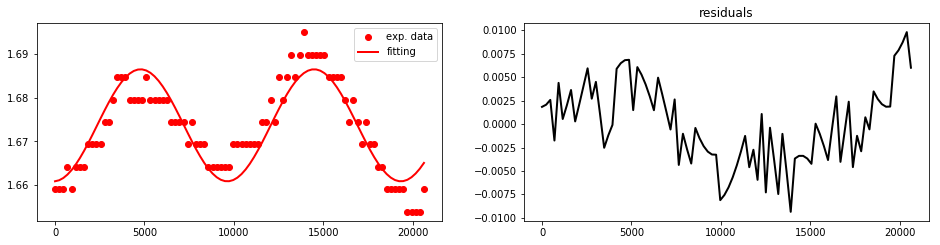

In [6]:
I_fitting=sin_func(par1, angles_1)
residuals=intensities_1-I_fitting

plot_experiment_residuals_1D(angles_1, intensities_1, I_fitting, title='')

In [7]:
I_mean=par1[0]
I_fluctuation=par1[1]
angle_min=par1[3]

print("Average intensity   = {:4.5}".format(I_mean))
print("Amplitude lineality = {:4.5}".format(I_fluctuation))
print("Angle min           = {:4.5}".format(angle_min))

Average intensity   = 1.6737
Amplitude lineality = -0.012761
Angle min           = -1.2386


This means that light is not purely circular, but it has a small component of elipticity.
We can determine the input light parameters by adjusting this parameters.

In [8]:
def I_incident_theory(par, theta):
    amplitude, angle, phase = par
    u0=polarized_light(amplitude, angle, phase, 1 )
   
    pol_param=get_polarimeter_parameters(kind='real')
    pol1,_,_,_=pol_param

    if type(theta) in [float, int]:
        P1 = polarizer_linear(p1=pol1['p1'], p2=pol1['p0'], theta=theta)
        I1= intensity(P1 * u0)    
    else:
        I1=sp.zeros_like(theta, dtype=float)
        for i, theta_i in enumerate(theta):
            P1 = polarizer_linear(p1=pol1['p1'], p2=pol1['p0'], theta=theta_i)
            I1[i] = intensity(P1 * u0)
    
    return I1    

In [9]:
err_func_I_incident = lambda par, x, y: I_incident_theory(par, x) - y # Distance to the target function

par0 = [1.7, sp.pi / 4, sp.pi / 2] # amplitude, angle, phase, poldegree=1
par1, success = optimize.leastsq(err_func_I_incident, par0[:], args=(angles_1*degrees, intensities_1))


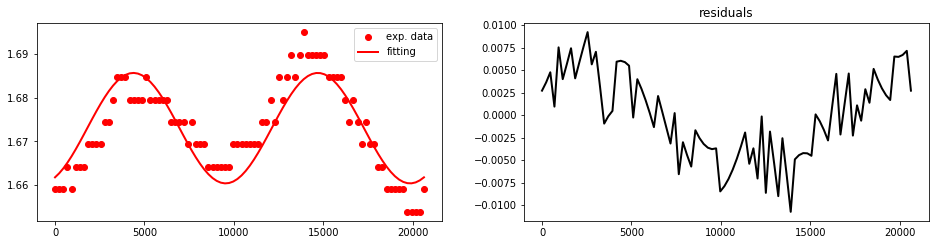

In [15]:
# Obtenido
I_fitting=I_incident_theory(par1, angles_1*degrees)
residuals=intensities_1-I_fitting
plot_experiment_residuals_1D(angles_1, intensities_1, I_fitting, title='')


## Resultados

In [11]:
print("Parameters of polarized light")
print("- amplitude   = {:4.5} V".format(par1[0]))
print("- angle       = {:4.5} º".format(par1[1]/degrees))
print("- phase       = {:4.5} º".format(par1[2]/degrees))

Parameters of polarized light
- amplitude   = 1.9377 V
- angle       = 45.199 º
- phase       = 89.796 º


###  Stokes Parameters

In [12]:
from polarimeter.polarimeter import get_light_parameters

aap, u0= get_light_parameters()
print(aap[0], aap[1]/degrees, aap[2]/degrees)

print("Stokes parameters = \n{}".format(u0))

1.8823 45.199 89.796
Stokes parameters = 
[[ 3.54305329]
 [-0.0246113 ]
 [ 0.01261461]
 [ 3.54294535]]


## Verificación
Aquí utilizamos el modelo numérico del polarímetro para verificar que se obtiene el resultado experimental

In [19]:
#Polarizer, Method 1 p0=0.132707197802, p1=0.964658186801, angulo=21.6801869438º
#Polarizer, Method 2 p0=0.12810158426, p1=0.934711947067, angulo=25.6030137073º

intensity_numerical=sp.zeros_like(angles_1,dtype=float)
for i, angle in enumerate(angles_1*degrees):
    P1 = polarizer_linear(p1=.964658186801, p2=0.132707197802, theta=angle)
    intensity_numerical[i]=intensity(P1*u0)

plt.figure()
plt.plot(angles_1, intensity_numerical,'k',label='numerical')
plt.plot(angles_1, intensities_1,'r', label='experimental')
plt.legend()

In [20]:
P1

matrix([[ 0.47408831,  0.45647711, -0.        ,  0.        ],
        [ 0.45647711,  0.47408831, -0.        ,  0.        ],
        [-0.        , -0.        ,  0.12801708,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.12801708]])